## Compute count-count correlation functions between lens catalog and source catalogs

# $w = \frac{LS - LR - SR +RR}{RR} $ 

 see eq.6 in https://arxiv.org/pdf/1111.3698.pdf

In [3]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
from sklearn.neighbors import KernelDensity
import coord


In [4]:
treecorr.__version__

'4.2.4'

In [5]:
matplotlib.rcParams.update({'font.size': 14})

In [6]:
#cosmo = extragalactic_cat.cosmology
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

In [7]:
def rand_cat(cat, Nobj, r=None, patch_centers=None, k=None):
    
    ra_min = np.min(cat.ra)
    ra_max = np.max(cat.ra)
    dec_min = np.min(cat.dec)
    dec_max = np.max(cat.dec)

    rand_ra = np.random.uniform(ra_min, ra_max, int(Nobj))
    rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), int(Nobj))
    rand_dec = np.arcsin(rand_sindec)
    
    if isinstance(k, KernelDensity):
        k_rand = k.sample(int(Nobj)).T[0]
    else:
        k_rand=None
        
    if isinstance(r, KernelDensity):
        r_rand = r.sample(int(Nobj)).T[0]
    else:
        r_rand=None
        
    if isinstance(patch_centers, type(None)):
        cat_rand= treecorr.Catalog(ra=rand_ra, dec=rand_dec, r = r_rand, ra_units='radians', dec_units='radians', k=k_rand)
    else:
        cat_rand = treecorr.Catalog(ra=rand_ra, dec=rand_dec, r = r_rand, ra_units='radians', dec_units='radians', k=k_rand, patch_centers =patch_centers)       

    return cat_rand

In [54]:
def corr_quantities_NN(cat_halo, cat, rand, bin_dict, rr=None, rd=None, patch_centers=None, kde=None):
    
    corr_type = treecorr.NNCorrelation
    
    if isinstance(cat_halo.r, np.ndarray):
        kde = KernelDensity(bandwidth=50, kernel='gaussian').fit((cat_halo.r).reshape(len(cat_halo.r),1))
    
    cat_rand_halo =  rand_cat(cat_halo, Nobj = cat_halo.ra.size, r = kde, patch_centers=patch_centers)
    
    ls = corr_type(**bin_dict)
    ls.process(cat_halo, cat)#,low_mem=True)
    
    ll = corr_type(**bin_dict)
    ll.process(cat_halo, cat_halo)#,low_mem=True)
    
    lr = corr_type(**bin_dict)
    lr.process(cat_halo, rand)#, low_mem=True)
    
    #xi, varxi = ls.calculateXi(rr, lr, rd)
    xi, varxi = ls.calculateXi(lr)
    r = np.exp(ls.meanlogr)
    sigxi = np.sqrt(varxi)
    covxi = ls.estimate_cov(bin_dict['var_method'])
    
    #ls_rand = corr_type(**bin_dict)
    #ls_rand.process(cat_rand_halo, cat)
    
    #lr_rand = corr_type(**bin_dict)
    #lr_rand.process(cat_rand_halo, rand)
    
    #xi_rand, varxi_rand = ls_rand.calculateXi(rr, lr_rand, rd)
    #r_rand = np.exp(ls_rand.meanlogr)
    #sigxi_rand = np.sqrt(varxi_rand)
    #covxi_rand = ls_rand.estimate_cov(bin_dict['var_method'])
    
    return r, xi, covxi#, r_rand, xi_rand, covxi_rand, ls, lr, ll

In [55]:
def corr_quantities_NK(cat_halo, cat, bin_dict, patch_centers=None, kde=None):
    
    corr_type = treecorr.NKCorrelation
    
    if isinstance(cat_halo.r, np.ndarray):
        kde = KernelDensity(bandwidth=50, kernel='gaussian').fit((cat_halo.r).reshape(len(cat_halo.r),1))
    
    cat_rand_halo =  rand_cat(cat_halo, Nobj = cat_halo.ra.size*100, r=kde, patch_centers=patch_centers)
    
    ls = corr_type(**bin_dict)
    
    ls.process(cat_halo, cat)#, low_mem=True)
    
    #lr = corr_type(**bin_dict)
    #lr.process(cat_halo, rand)
    
    ls_rand = corr_type(**bin_dict)
    ls_rand.process(cat_rand_halo, cat)#, low_mem=True)
    
    xi, varxi = ls.calculateXi()
    r = np.exp(ls.meanlogr)
    sigxi = np.sqrt(varxi)
    covxi = ls.estimate_cov(bin_dict['var_method'])
    

    return r, xi, covxi, ls.npairs

In [10]:
def corr_plot(r, xi, sigxi, r_rand=None, xi_rand=None, sigxi_rand=None, fig=None, ax=None, corr=False, label=r'$\delta_{\mu}$'):
    if fig==None:
        fig, ax = plt.subplots(1,1)
    
    if corr==True:
        sigxi = np.sqrt(np.diag(sigxi))
        if sigxi_rand!=None :
            sigxi_rand = np.sqrt(np.diag(sigxi_rand))
    
    ax.errorbar(r, xi, yerr= sigxi, color='red', fmt='.')
    if r_rand!= None and xi_rand!=None and sigxi_rand!=None :
        ax.fill_between(r_rand, y1= xi_rand - sigxi_rand, y2 = xi_rand + sigxi_rand, color='grey',alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel(r'$\theta$ (Mpc)')
    ax.set_ylabel(label)
    return fig, ax

## Open halo catalog and define binning

In [11]:
path_file = '../../'

In [12]:
halo_cat =  pd.read_hdf(path_file + 'input_data/cat_halos.h5')

In [13]:
len(halo_cat)

1282562

In [14]:
zbins = np.array(([0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1.0], [1.0, 1.2]))

In [15]:
mbins = np.array(([20,30],[30,45],[45,70],[70,120],[120,220]))*(1e14/45)

In [16]:
bin_sel = np.zeros((zbins.shape[0], mbins.shape[0]), dtype=object)
for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        bin_sel[i,j] = (halo_cat['redshift']> zbins[i][0]) & (halo_cat['redshift']< zbins[i][1]) & (halo_cat['halo_mass']> mbins[j][0]) & (halo_cat['halo_mass']< mbins[j][1])

In [17]:
wide_selection =  (halo_cat['redshift']> zbins.min()) & (halo_cat['redshift']< zbins.max()) & (halo_cat['halo_mass']> mbins.min()) & (halo_cat['halo_mass']< mbins.max())

In [18]:
# Create list for all the error patches
binboxes = []

# Loop over data points; create box from errors at each point
for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        rect = matplotlib.patches.Rectangle((zbins[i][0], mbins[j][0]), zbins[i][1] - zbins[i][0], mbins[j][1]-mbins[j][0])
        binboxes.append(rect)

    # Create patch collection with specified colour/alpha
pc = matplotlib.collections.PatchCollection(binboxes, linewidth=3,edgecolor='r',facecolor='none')


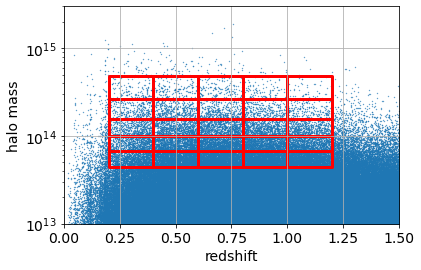

In [19]:
plt.scatter(halo_cat['redshift'], halo_cat['halo_mass'], s=0.1)
plt.yscale('log')


plt.xlabel('redshift')
plt.ylabel('halo mass')

plt.gca().add_collection(pc)
plt.grid()

plt.xlim(0,1.5)
plt.ylim(1e13, 3e15);

## Open source catalog 

In [20]:
key = 'LBGp'

gal_cat =  pd.read_hdf(path_file + 'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file + "input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null, gal_dens, zmean = dat[np.where(dat[:,0]==key)][0][1:]
print (alpha_cut)
mag_cut

3.320964657712193


25.495

### Selection of squared region 

In [21]:
#DC2 full

selection_halo = ( halo_cat['ra']>50) & ( halo_cat['ra']<73.1) & ( halo_cat['dec']<-27.) & ( halo_cat['dec']>-45.)
selection_source = ( gal_cat['ra']>50) & ( gal_cat['ra']<73.1) & ( gal_cat['dec']<-27.) & ( gal_cat['dec']>-45.)

area_eq = (73.1 - 50)*(-27 - -45.)

print("selected area =" , area_eq, "deg2")

selected area = 415.7999999999999 deg2


## Creation of the treecorr source catalog

In [30]:
Np = 10
selection = selection_source & (gal_cat['mag_i_lsst']<mag_cut) & (gal_cat['redshift']>1.5)

cat = treecorr.Catalog(ra = gal_cat['ra'][selection], dec = gal_cat['dec'][selection], k = gal_cat['magnification'][selection], ra_units='deg', dec_units='deg', npatch=Np)

## Create random source catalog with same area

In [56]:
Ntimes = 100
rand = rand_cat(cat, Nobj = cat.ra.size * Ntimes)#,  patch_centers=cat.patch_centers)#, kde=kde)

## Create lens catalogs

In [32]:
selection_lens = selection_halo &  wide_selection
redshift_mean, halo_mass_mean = halo_cat['redshift'][selection_lens].mean(), halo_cat['halo_mass'][selection_lens].mean()
print("<z> =", redshift_mean , ", <halo_mass> =", halo_mass_mean/1e14 )

cat_lens = treecorr.Catalog(ra = halo_cat['ra'][selection_halo], dec = halo_cat['dec'][selection_halo], r =  cosmo.angular_diameter_distance(halo_cat['redshift'][selection_halo]).value, ra_units='deg', dec_units='deg', npatch=Np),# patch_centers=cat.patch_centers)

<z> = 0.7332933430025187 , <halo_mass> = 0.8628683058448181


### Lens catalogs in bins of halo mass / redshift

In [33]:
cat_lens_i = np.empty(bin_sel.shape,dtype="object")
quant = np.empty(bin_sel.shape,dtype="object")
quant_NK = np.empty(bin_sel.shape,dtype="object")

In [44]:
bin_dict={'min_sep':0.1, 'max_sep':7,'bin_type':'Log','nbins':10, 'var_method':'jackknife', 'metric': 'Rlens'}

In [57]:
z_cl = np.zeros((5,5))
mass_cl = np.zeros((5,5))
n_halo = np.zeros((5,5))

patch_centers = cat.patch_centers

for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        
        selection_lens = selection_halo * bin_sel[i,j]
        z_cl[i,j], mass_cl[i,j] = halo_cat['redshift'][selection_lens].mean(), halo_cat['halo_mass'][selection_lens].mean()
        n_halo[i,j] = halo_cat['redshift'][selection_lens].size
        print("<z> =", z_cl[i,j] , ", <halo_mass> =", mass_cl[i,j]/1e14, "N halo :", n_halo[i,j])

 
        cat_lens_i[i,j] = treecorr.Catalog(ra = halo_cat['ra'][selection_lens], dec = halo_cat['dec'][selection_lens], r = cosmo.angular_diameter_distance(halo_cat['redshift'][selection_lens]).value, ra_units='deg', dec_units='deg', patch_centers=patch_centers)
        
        quant[i,j] = corr_quantities_NN(cat_lens_i[i,j], cat, rand, bin_dict=bin_dict, patch_centers=patch_centers)[0:6]
        
        quant_NK[i,j] = corr_quantities_NK(cat_lens_i[i,j], cat, bin_dict=bin_dict, patch_centers=patch_centers)

/pbs/throng/lsst/users/mricci/desc/my_clean_env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


<z> = 0.31607957121219615 , <halo_mass> = 0.5368857375264066 N halo : 1142.0


KeyboardInterrupt: 

## Check outputs

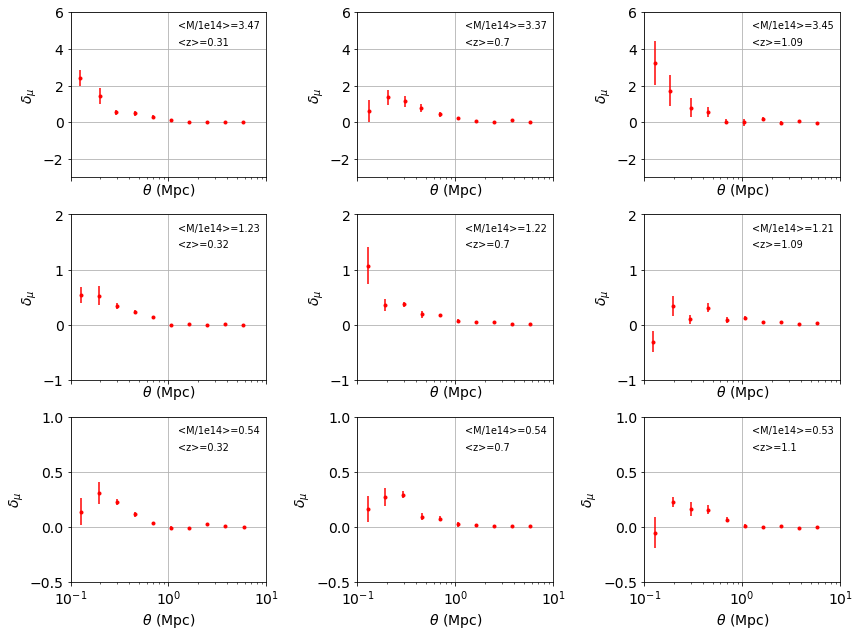

In [46]:
fig, axes = plt.subplots( 3,3, figsize=[12,9], sharex=True)
for i,h in zip([0,2,4],range(3)):
    for j,k in zip([0,2,4],range(3)):
        
        f, ax =  corr_plot(*quant[i,j], fig=fig, ax=axes[3-1-k,h], corr=True)

        ax.set_xlim(0.1,10)
        
        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        
plt.tight_layout()

for i in range(axes.shape[0]):
    axes[2,i].set_ylim(-0.5,1)
    axes[1,i].set_ylim(-1,2)
    axes[0,i].set_ylim(-3,6)
    for j in range(axes.shape[1]):
        axes[i,j].set_xlim(0.1,10)

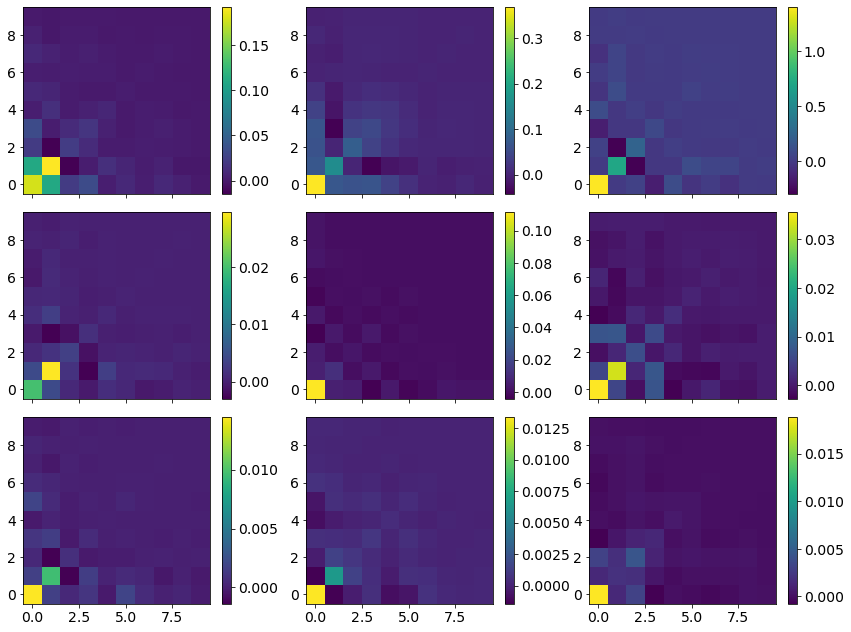

In [47]:
i,j = 4,2

fig, axes = plt.subplots( 3,3, figsize=[12,9], sharex=True)
for i,h in zip([0,2,4],range(3)):
    for j,k in zip([0,2,4],range(3)):
        
        im = axes[3-1-k,h].imshow(quant[i,j][2], origin='lower')#, vmin=-0.5,vmax=0.5)
        fig.colorbar(im, ax=axes[3-1-k,h])
        
plt.tight_layout()

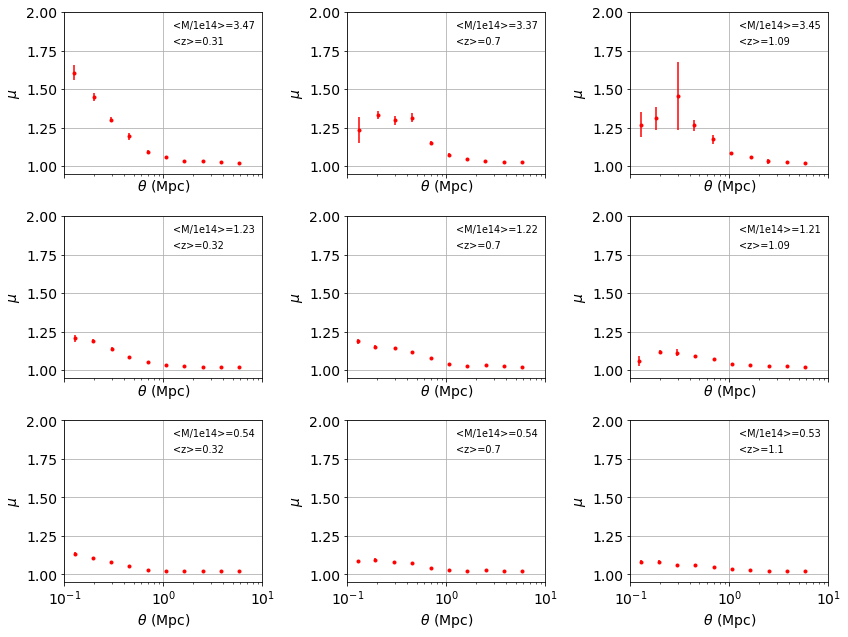

In [48]:
fig, axes = plt.subplots( 3,3, figsize=[12,9], sharex=True)
for i,h in zip([0,2,4],range(3)):
    for j,k in zip([0,2,4],range(3)):
        
        f, ax =  corr_plot(quant_NK[i,j][0], quant_NK[i,j][1], quant_NK[i,j][2], fig=fig, ax=axes[3-1-k,h], corr=True, label=r'$\mu$')

        ax.set_xlim(0.1,10)
        
        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        
plt.tight_layout()

for i in range(axes.shape[0]):
    axes[2,i].set_ylim(0.95,2)
    axes[1,i].set_ylim(0.95,2)
    axes[0,i].set_ylim(0.95,2)
    for j in range(axes.shape[1]):
        axes[i,j].set_xlim(0.1,10)

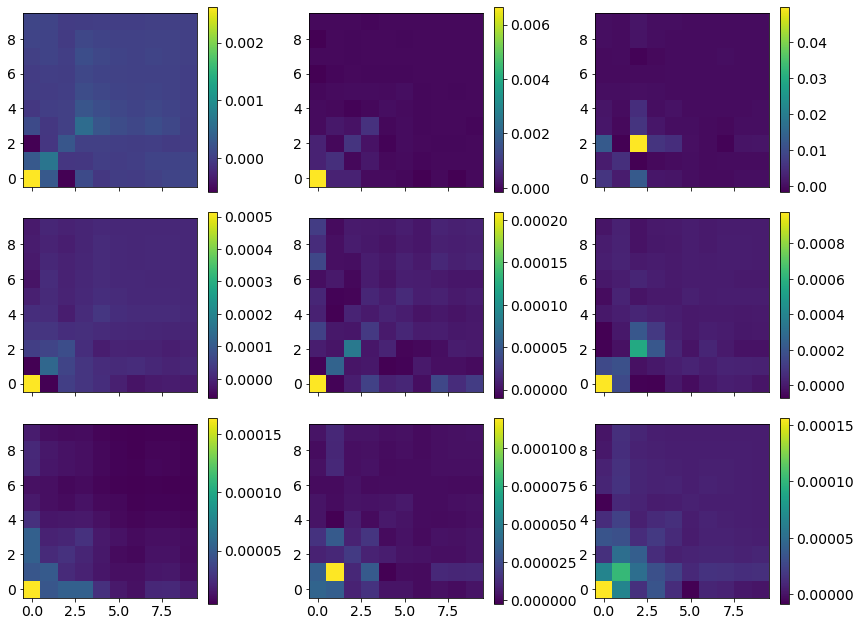

In [49]:
i,j = 4,2

fig, axes = plt.subplots( 3,3, figsize=[12,9], sharex=True)
for i,h in zip([0,2,4],range(3)):
    for j,k in zip([0,2,4],range(3)):
        
        im = axes[3-1-k,h].imshow(quant_NK[i,j][2], origin='lower')#, vmin=-0.5,vmax=0.5)
        fig.colorbar(im, ax=axes[3-1-k,h])
        
plt.tight_layout()

## Save outputs

In [52]:
np.save(path_file + 'output_data/binned_correleation_fct_Mpc_'+key, quant)
np.save(path_file + 'output_data/binned_correleation_fct_NK_Mpc_'+key, quant_NK)

In [53]:
np.save(path_file + "halo_bin_properties", [z_cl, mass_cl,n_halo])